# Data Regression Approach 2 (Imputed Data)

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import psycopg2
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import svm
%matplotlib inline

/Users/johnsnyder/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
data = pd.read_csv('/Users/johnsnyder/GA-DSI-working/Capstone/EMI/clean_data_mean_imputes.csv')
data = data.drop('Unnamed: 0', axis=1)
data.head()

,Artist,Track,User,Rating,Time,Aggressive,Edgy,Thoughtful,Serious,Good lyrics,...,LIST_OWN_1.0,LIST_OWN_2.0,LIST_OWN_3.0,LIST_OWN_4.0,LIST_OWN_5.0,LIST_BACK_1.0,LIST_BACK_2.0,LIST_BACK_3.0,LIST_BACK_4.0,LIST_BACK_5.0
0,40,179,47994,9,17,0.000000,0.0,0.0,0.000000,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,23,8575,58,7,0.045448,0.0,0.0,0.054533,0.165237,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,46,168,45475,13,16,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,153,39508,42,15,0.000000,1.0,0.0,1.000000,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14,32,11565,54,19,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
data.shape

(188690, 109)

In [5]:
n_users = data.User.nunique()
n_artists = data.Artist.nunique()

In [6]:
# Take a quick look at the sparsity of our dataset.
sparsity=round(1.0-len(data)/float(n_users*n_artists),3)
print('The sparsity level of the dataset is ' +  str(sparsity*100) + '%')

The sparsity level of the dataset is 92.4%


In [9]:
from sklearn.metrics import mean_squared_error as mse
from math import sqrt

In [10]:
result = data['Artist'].unique()

In [11]:
## Double-checking number of artists we're using in our final dataset.
counteryes = 0
counterno = 0
for ID in range(0,50,1):    #50 total artist IDs, ranging from 0 to 49:
    if ID in result:
        counteryes +=1
    else:
        counterno += 1
        print 'OUT: {}'.format(ID)
        
print "Percent of artists remaining in dataset: {:.2%}".format(float(counteryes) / (counteryes + counterno))

Percent of artists remaining in dataset: 100.00%


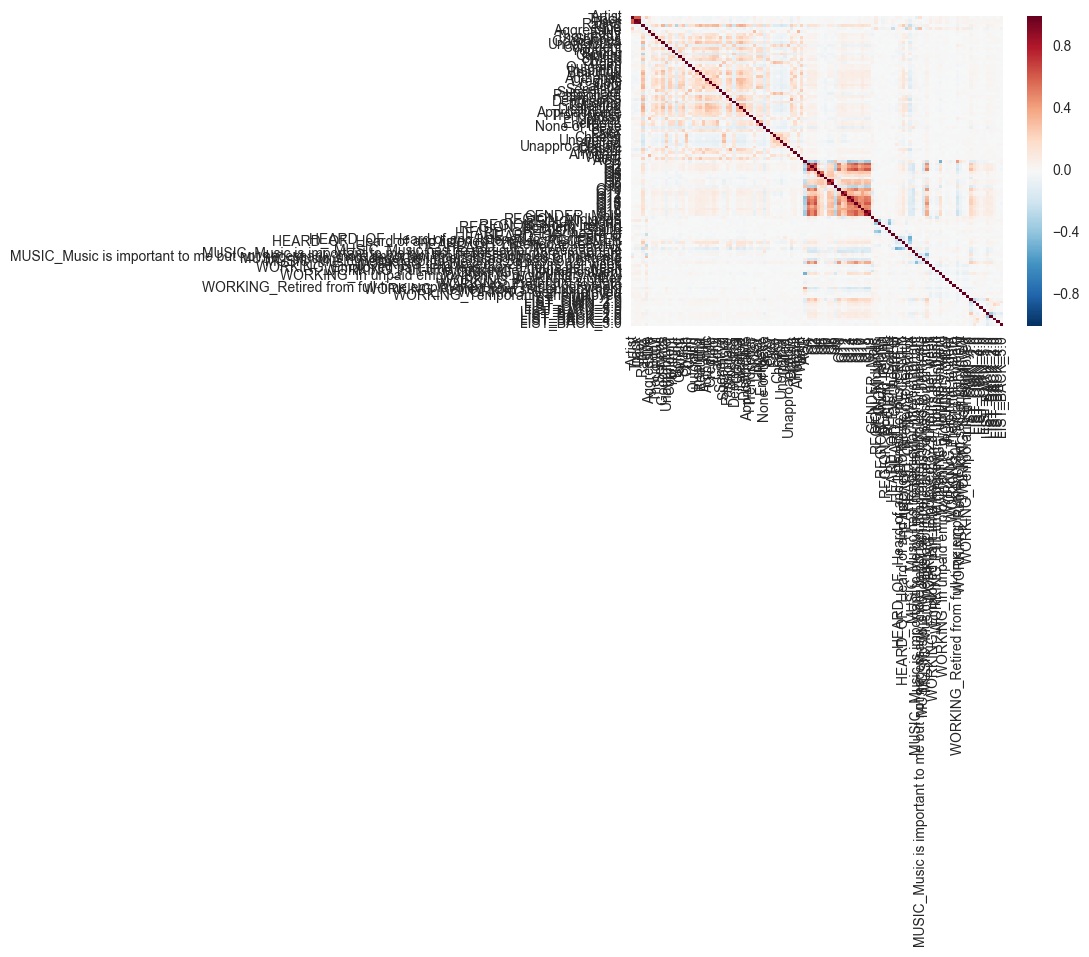

In [15]:
sns.heatmap(data.corr())

In [12]:
# Split training and testing data
X = data.drop(['Rating'], axis=1)
y = data['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

# Random Forest, 2,000 estimators

In [17]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [18]:
reg_RF = RandomForestRegressor(n_estimators=2000, n_jobs=3)

In [19]:
reg_RF.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=2000, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [20]:
RF_predictions = reg_RF.predict(X_test)

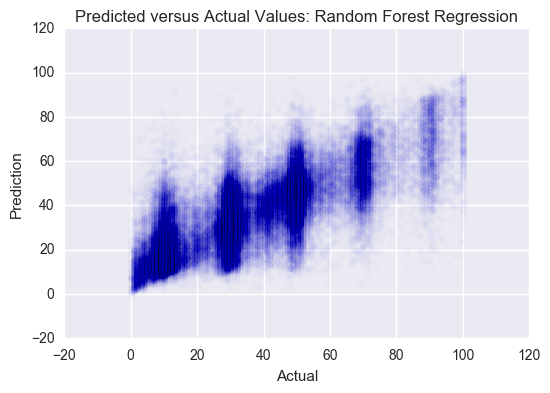

In [21]:
plt.scatter(y_test, RF_predictions, alpha=0.01)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Predicted versus Actual Values: Random Forest Regression")

In [22]:
from sklearn import metrics
print 'MAE:', metrics.mean_absolute_error(y_test, RF_predictions)
print 'MSE:', metrics.mean_squared_error(y_test, RF_predictions)
print 'RMSE:', np.sqrt(metrics.mean_squared_error(y_test, RF_predictions))

MAE: 11.0018776631
MSE: 219.177630207
RMSE: 14.804648939


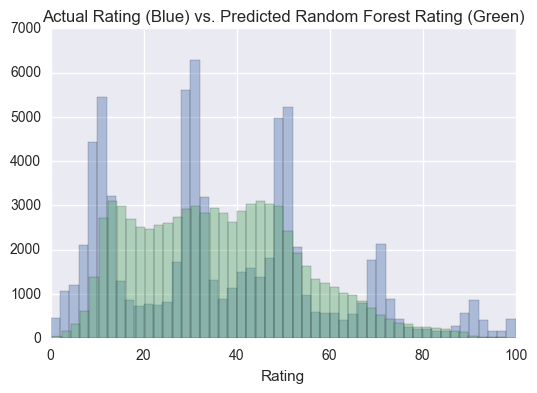

In [28]:
sns.distplot(y_test, kde=False)
sns.distplot(RF_predictions, kde=False)
plt.title('Actual Rating (Blue) vs. Predicted Random Forest Rating (Green)');

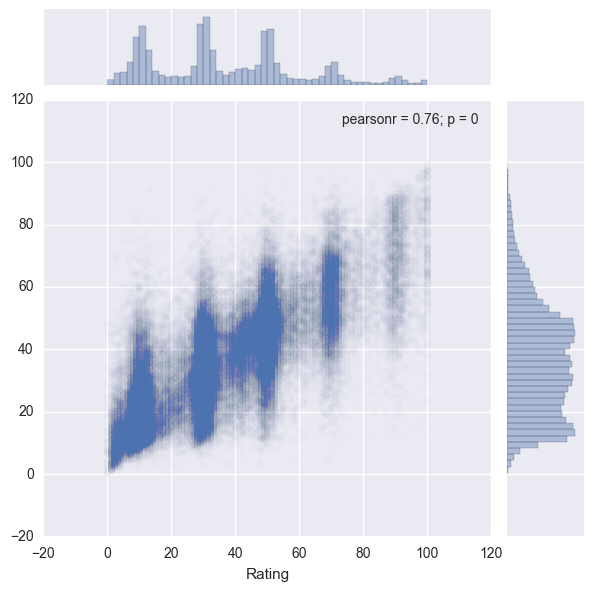

In [29]:
sns.jointplot(y_test, RF_predictions, alpha=0.01)

# Random Forest Regression with Top 26 Features

In [45]:
feature_importance = pd.DataFrame({'Feature': X_test.columns, 'Importance': reg_RF.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending = False)
top_features = feature_importance['Feature'][:26]

In [46]:
top_features

31                                            Talented
1                                                Track
19                                           Beautiful
24                                              Catchy
12                                              Boring
2                                                 User
32                                         Distinctive
61                                                 Q11
50                                                 AGE
54                                                  Q4
67                                                 Q17
56                                                  Q6
78    HEARD_OF_Heard of and listened to music RECENTLY
59                                                  Q9
62                                                 Q12
66                                                 Q16
57                                                  Q7
55                                                  Q5
58        

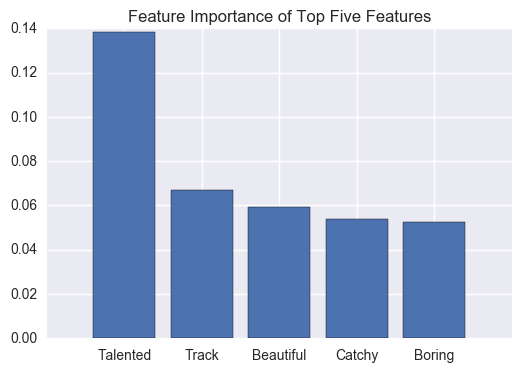

In [49]:
#Plotting bar chart of top 5 features
top_to_plot = feature_importance.sort_values(by='Importance', ascending=False)[:5]
labels = ['Talented', 'Track', 'Beautiful', 'Catchy', 'Boring']
plt.bar([0, 1, 2, 3, 4], list(top_to_plot['Importance']), align = 'center', tick_label = labels)
plt.title('Feature Importance of Top Five Features');

In [50]:
# Split training and testing data
X_tf = data[top_features]
y_tf = data['Rating']
X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(X_tf, y_tf, test_size=0.4, random_state=101)


In [ ]:
reg_RF_tf = RandomForestRegressor(n_estimators=2000)
reg_RF_tf.fit(X_tf_train, y_tf_train)
RF_tf_predictions = reg_RF_tf.predict(X_tf_test)


In [ ]:
plt.scatter(y_tf_test, RF_tf_predictions, alpha=0.01)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Predicted versus Actual Values: Random Forest Regression w/Top Features")

In [ ]:
print 'MAE:', metrics.mean_absolute_error(y_test, RF_predictions)
print 'MSE:', metrics.mean_squared_error(y_test, RF_predictions)
print 'RMSE:', np.sqrt(metrics.mean_squared_error(y_test, RF_predictions))

In [ ]:
sns.distplot(y_tf_test)
sns.distplot(RF_tf_predictions)
plt.title('Actual Rating (Blue) vs. Predicted Random Forest Rating (Green)');

# Random Forest, 2,000 estimators, max depth = 2

In [36]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [37]:
reg_RF_2 = RandomForestRegressor(n_estimators=2000, n_jobs=3, max_depth=2)

In [38]:
reg_RF_2.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=2000, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [39]:
RF_2_predictions = reg_RF_2.predict(X_test)

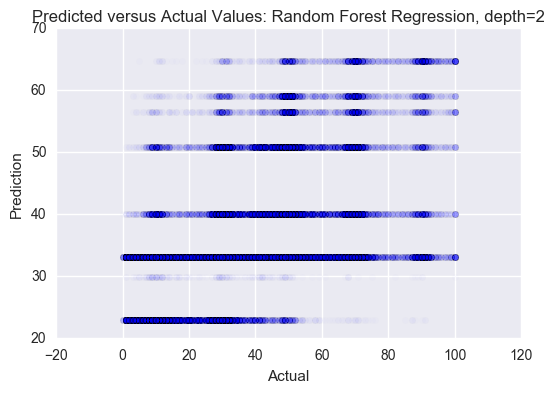

In [40]:
plt.scatter(y_test, RF_2_predictions, alpha=0.01)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Predicted versus Actual Values: Random Forest Regression, depth=2")

In [41]:
from sklearn import metrics
print 'MAE:', metrics.mean_absolute_error(y_test, RF_2_predictions)
print 'MSE:', metrics.mean_squared_error(y_test, RF_2_predictions)
print 'RMSE:', np.sqrt(metrics.mean_squared_error(y_test, RF_2_predictions))

MAE: 15.8012916382
MSE: 386.213993761
RMSE: 19.6523279476


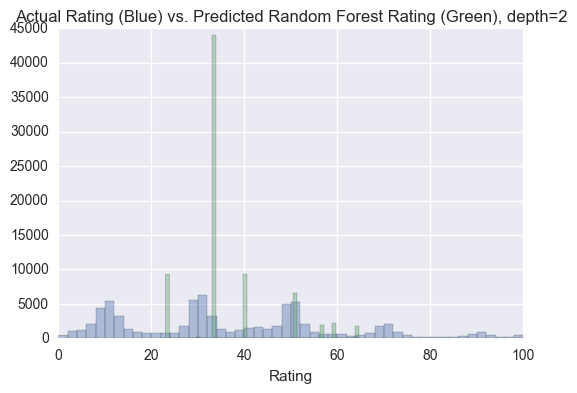

In [42]:
sns.distplot(y_test, kde=False)
sns.distplot(RF_2_predictions, kde=False)
plt.title('Actual Rating (Blue) vs. Predicted Random Forest Rating (Green), depth=2');

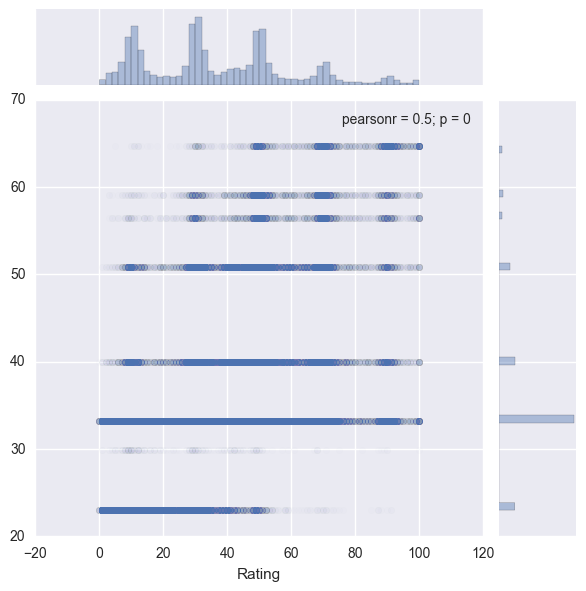

In [43]:
sns.jointplot(y_test, RF_2_predictions, alpha=0.01)

# Random Forest, 2,000 estimators, max depth = 3

In [44]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [45]:
reg_RF_3 = RandomForestRegressor(n_estimators=2000, n_jobs=3, max_depth=3)

In [46]:
reg_RF_3.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=2000, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [47]:
RF_3_predictions = reg_RF_3.predict(X_test)

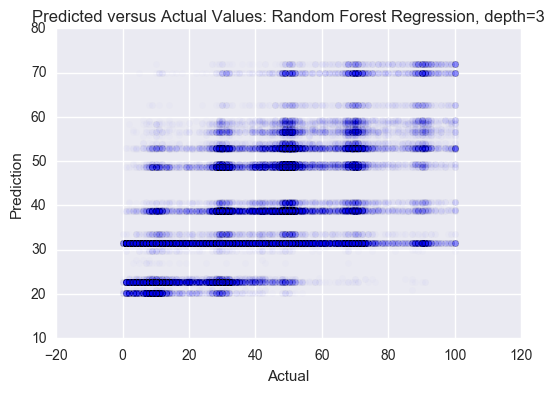

In [48]:
plt.scatter(y_test, RF_3_predictions, alpha=0.01)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Predicted versus Actual Values: Random Forest Regression, depth=3")

In [49]:
from sklearn import metrics
print 'MAE:', metrics.mean_absolute_error(y_test, RF_3_predictions)
print 'MSE:', metrics.mean_squared_error(y_test, RF_3_predictions)
print 'RMSE:', np.sqrt(metrics.mean_squared_error(y_test, RF_3_predictions))

MAE: 15.0239649738
MSE: 356.246062206
RMSE: 18.8744817732


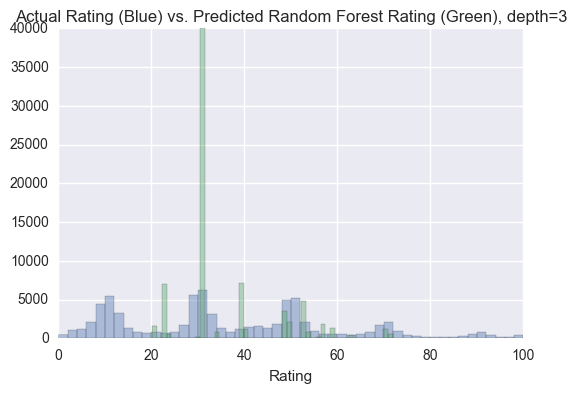

In [50]:
sns.distplot(y_test, kde=False)
sns.distplot(RF_3_predictions, kde=False)
plt.title('Actual Rating (Blue) vs. Predicted Random Forest Rating (Green), depth=3');

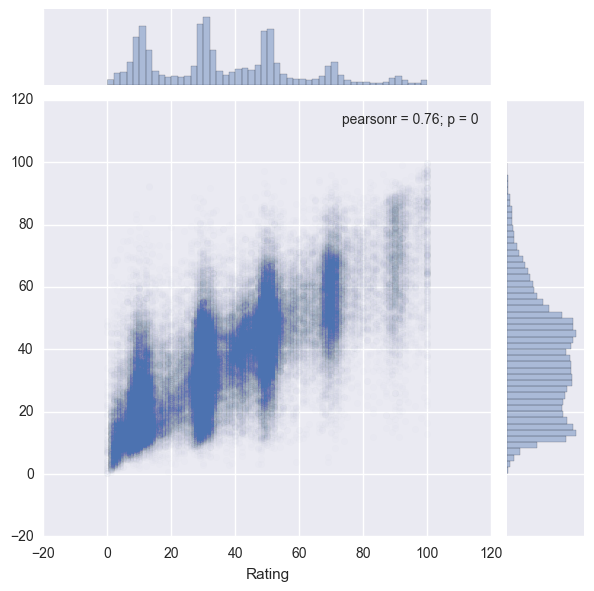

In [51]:
sns.jointplot(y_test, RF_predictions, alpha=0.01)

# Random Forest, 2,000 estimators, max depth = 4

In [52]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [53]:
reg_RF_4 = RandomForestRegressor(n_estimators=2000, n_jobs=3, max_depth=4)

In [54]:
reg_RF_4.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=2000, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [55]:
RF_4_predictions = reg_RF_4.predict(X_test)

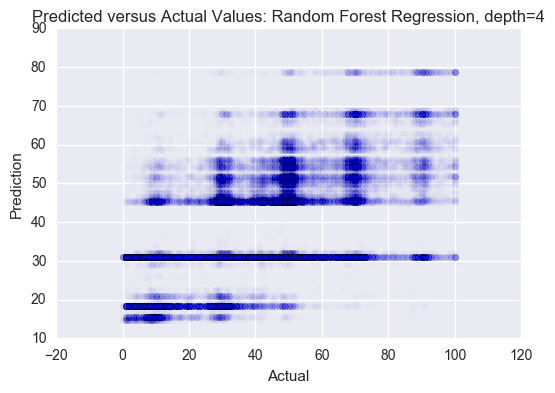

In [56]:
plt.scatter(y_test, RF_4_predictions, alpha=0.01)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Predicted versus Actual Values: Random Forest Regression, depth=4")

In [57]:
from sklearn import metrics
print 'MAE:', metrics.mean_absolute_error(y_test, RF_4_predictions)
print 'MSE:', metrics.mean_squared_error(y_test, RF_4_predictions)
print 'RMSE:', np.sqrt(metrics.mean_squared_error(y_test, RF_4_predictions))

MAE: 14.5658697542
MSE: 343.314076123
RMSE: 18.5287364956


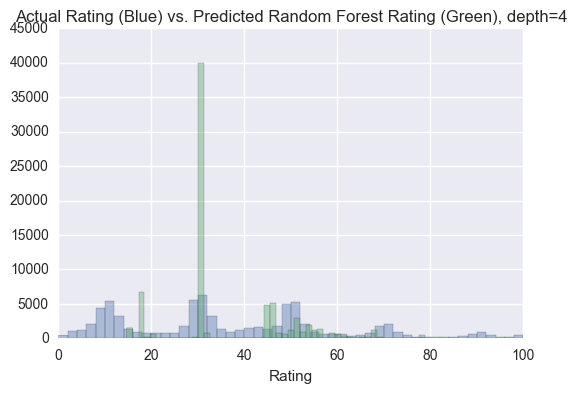

In [58]:
sns.distplot(y_test, kde=False)
sns.distplot(RF_4_predictions, kde=False)
plt.title('Actual Rating (Blue) vs. Predicted Random Forest Rating (Green), depth=4');

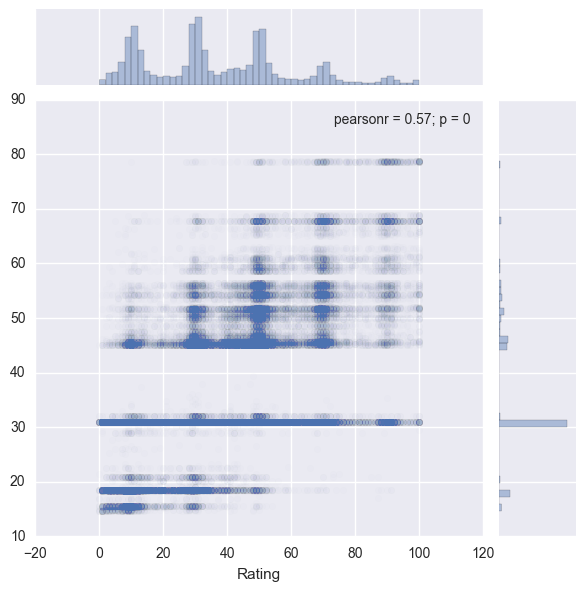

In [59]:
sns.jointplot(y_test, RF_4_predictions, alpha=0.01)

# Random Forest, 2,000 estimators, max depth = 5

In [60]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [61]:
reg_RF_5 = RandomForestRegressor(n_estimators=2000, n_jobs=3, max_depth=5)

In [62]:
reg_RF_5.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=2000, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [63]:
RF_5_predictions = reg_RF_5.predict(X_test)

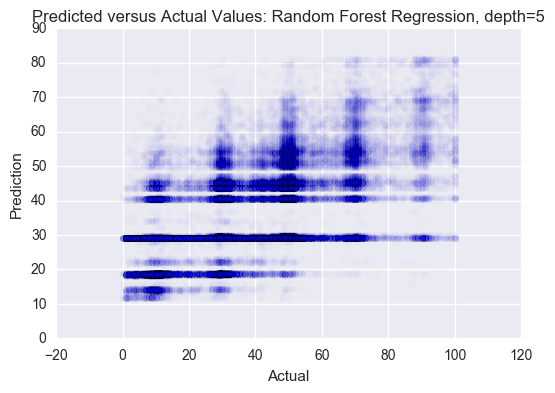

In [64]:
plt.scatter(y_test, RF_5_predictions, alpha=0.01)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Predicted versus Actual Values: Random Forest Regression, depth=5")

In [65]:
from sklearn import metrics
print 'MAE:', metrics.mean_absolute_error(y_test, RF_5_predictions)
print 'MSE:', metrics.mean_squared_error(y_test, RF_5_predictions)
print 'RMSE:', np.sqrt(metrics.mean_squared_error(y_test, RF_5_predictions))

MAE: 14.2784001663
MSE: 328.662097399
RMSE: 18.1290401676


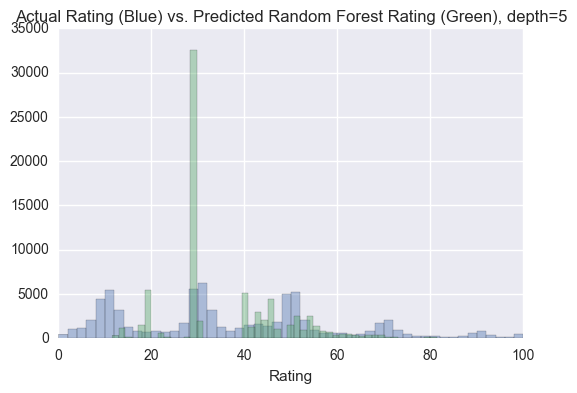

In [66]:
sns.distplot(y_test, kde=False)
sns.distplot(RF_5_predictions, kde=False)
plt.title('Actual Rating (Blue) vs. Predicted Random Forest Rating (Green), depth=5');

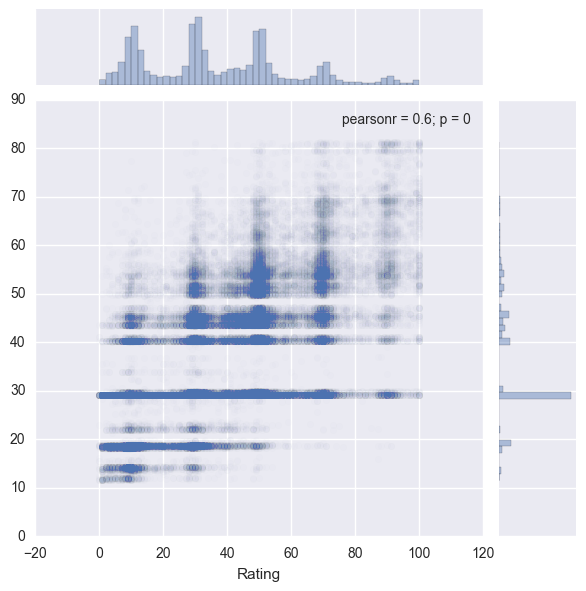

In [67]:
sns.jointplot(y_test, RF_5_predictions, alpha=0.01)

# Random Forest, 2,000 estimators, max depth = 6

In [68]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [69]:
reg_RF_6 = RandomForestRegressor(n_estimators=2000, n_jobs=3, max_depth=6)

In [70]:
reg_RF_6.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=2000, n_jobs=3, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [71]:
RF_6_predictions = reg_RF_6.predict(X_test)

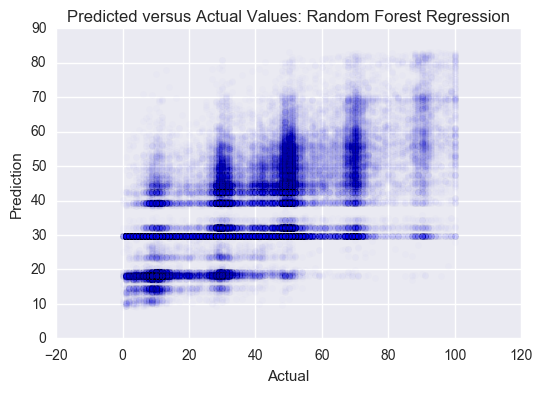

In [72]:
plt.scatter(y_test, RF_6_predictions, alpha=0.01)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title("Predicted versus Actual Values: Random Forest Regression")

In [73]:
from sklearn import metrics
print 'MAE:', metrics.mean_absolute_error(y_test, RF_6_predictions)
print 'MSE:', metrics.mean_squared_error(y_test, RF_6_predictions)
print 'RMSE:', np.sqrt(metrics.mean_squared_error(y_test, RF_6_predictions))

MAE: 13.9138773198
MSE: 314.373634107
RMSE: 17.7305847085


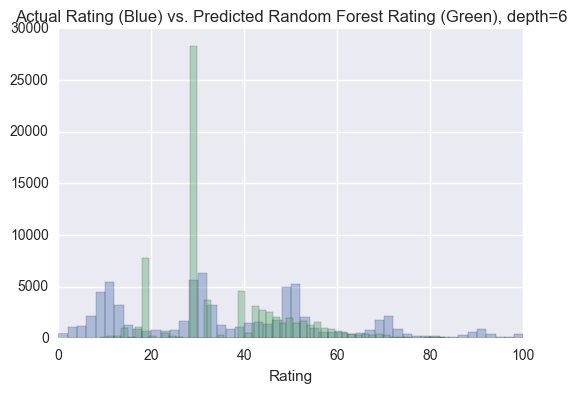

In [74]:
sns.distplot(y_test, kde=False)
sns.distplot(RF_6_predictions, kde=False)
plt.title('Actual Rating (Blue) vs. Predicted Random Forest Rating (Green), depth=6');

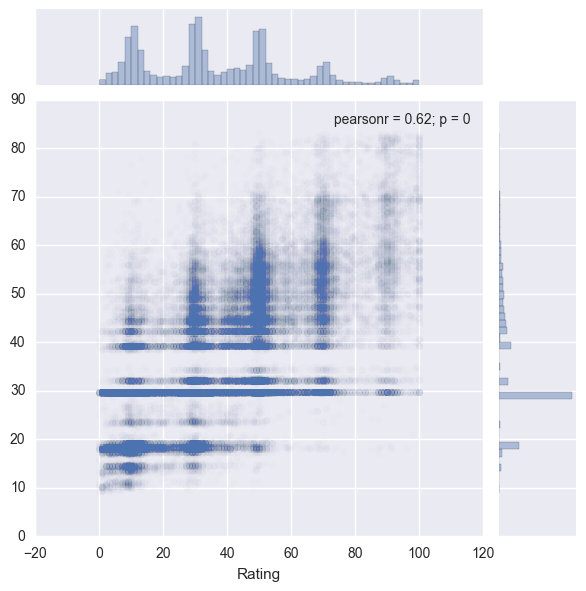

In [75]:
sns.jointplot(y_test, RF_6_predictions, alpha=0.01)